INPUT: Folder/scenario name\
OUTPUT: CSV file with mean reward, stdev, and metadata. Plot of training curve.

Plot Learning Curves

In [33]:
import json
import os
import numpy as np
import pandas as pd

sanity_check = False

root_dir = f'../sacred/confidentiality_medium/'

def buid_result_df_train(root_dir):
    # Create empty dataframe
    df = pd.DataFrame()

    # Iterate through each folder
    for root, dirs, files in os.walk(root_dir):
        for file in files:

            # Check for eval directory name if running in mode
            if "eval" in os.path.join(root, file):
                continue
        
            if "qmix" not in os.path.join(root, file):
                continue

            # Check if info.json and config.json exist
            if 'info.json' in files and 'config.json' in files:
                
                # prints every filename, crude detection of misformed json
                if sanity_check:
                    print(f'{os.path.join(root, file)}')

                # Read the info file
                with open(os.path.join(root, 'info.json')) as info_f:
                    data = json.load(info_f)

                # Read the config file
                with open(os.path.join(root, 'config.json')) as config_f:
                    config = json.load(config_f)

                # Extract return_mean and return_mean_T values from the json
                return_mean = [sample['value'] for sample in data['return_mean']]
                return_std = [sample['value'] for sample in data['return_std']]
                return_mean_T = data['return_mean_T']

                # Put the values in a numpy array
                info_arr = np.array([return_mean_T, return_mean, return_std]).T

                # Convert the numpy array to a pandas dataframe
                df_info = pd.DataFrame(info_arr, columns=['ts', 'return_mean', 'return_stdev'])

                # Loop through the config file and add the variables as columns
                for key, value in config.items():
                    try: 
                        df_info[key] = value
                    except:
                        ValueError(f"Could not read {os.path.join(root, file)}")
                    # Add variables from sub dict
                    if key == 'env_args':
                        for arg_key, arg_val in value.items():
                            df_info[arg_key] = arg_val
                    df_info['path'] = root
                
                # Sanity check:
                for i in df_info['path']:
                    #check if there is at least one corresponding value in column 'ts' that is greater than 990,000
                    if df_info[df_info['path'] == i]['ts'].max() > 990000:
                        pass
                    else:
                        #print("The run at {} did not exceed 990,000 timesteps.".format(i))
                        if file == 'info.json':
                            print(f'This run does not exceed 990,000 timesteps: {os.path.join(root, file)}')
                        break

                # Append file info to dataset
                df = pd.concat([df, df_info])
            elif 'info.json' not in files and file == 'config.json':
                print(f'This run is likely corrupted: {os.path.join(root, file)}')
    return df

df = buid_result_df_train(root_dir)

if df.empty:
    print("No data met the criteria.")
else:
    # rename mac to algorithm
    df.loc[df['mac']=='n_mac', 'mac'] = 'qmix'
    df.loc[df['mac']=='basic_mac', 'mac'] = 'iql'
    df.loc[df['learner']=='ppo_learner', 'mac'] = 'ppo'
    df.loc[(df['map_name'] == 'confidentiality_hard_single') & (df['mac'] == 'iql'), 'mac'] = 'dqn'
    df.rename(columns={'mac': 'algorithm'}, inplace=True)

    # rename spec config
    df.loc[df['no_obs']==True, 'wrapper_type'] = 'no_obs'

    df.to_csv(f'../datasets/temp.csv')
    print(df.groupby([ 'algorithm', 'map_name', 'wrapper_type'])['seed'].nunique())

This run does not exceed 990,000 timesteps: ../sacred/confidentiality_medium/qmix_confidentiality_medium_no_obs\1\info.json
This run does not exceed 990,000 timesteps: ../sacred/confidentiality_medium/qmix_confidentiality_medium_no_obs\2\info.json
This run does not exceed 990,000 timesteps: ../sacred/confidentiality_medium/qmix_confidentiality_medium_table\1\info.json
This run does not exceed 990,000 timesteps: ../sacred/confidentiality_medium/qmix_confidentiality_medium_table\10\info.json
This run is likely corrupted: ../sacred/confidentiality_medium/qmix_confidentiality_medium_table\12\config.json
This run is likely corrupted: ../sacred/confidentiality_medium/qmix_confidentiality_medium_table\13\config.json
This run is likely corrupted: ../sacred/confidentiality_medium/qmix_confidentiality_medium_table\14\config.json
This run does not exceed 990,000 timesteps: ../sacred/confidentiality_medium/qmix_confidentiality_medium_table\15\info.json
This run is likely corrupted: ../sacred/confi

In [2]:
import pandas as pd
df = pd.read_csv('../datasets/temp.csv')

C:\Users\wiebe\AppData\Local\Temp\ipykernel_1844\3831534467.py:14: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.relplot(data=df_pl,


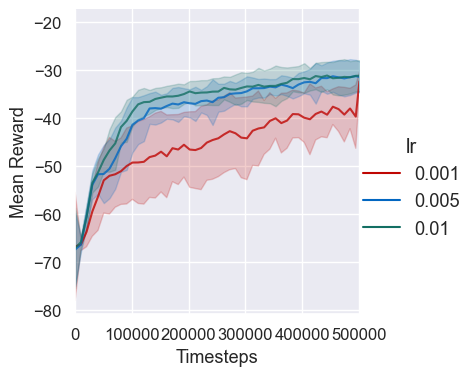

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

maps_to_display = {'confidentiality_medium': 'Confidentiality Medium',
                    }


df_pl = df[df['map_name'].isin(maps_to_display.keys())]

sns.set(style='darkgrid')
sns.set_context("notebook",  font_scale=1.2, rc={"xtick.labelsize":12, "ytick.labelsize":12, "axes.labelsize":13})
# Plot facets
g = sns.relplot(data=df_pl, 
                x='ts', y='return_mean', 
                hue='lr',
                kind='line', 
                #legend=None, 
                sort=True, 
                dashes=False, markers=False, 
                alpha=0.8, height=4, aspect=1,
                errorbar='sd', 
                palette=['#BF0603',  '#0267C1', '#136F63', '#9A5B8B', ], 
                #col='batch_size',
                #estimator='median'
                )

g.set(xlabel='Timesteps', ylabel='Mean Reward')
g.set(xlim=(0, 500000))
#g.set(ylim=(-75, 0))

# Make a custom legend
iql_line = mlines.Line2D([], [], color='#BF0603')
qmix_line = mlines.Line2D([], [], color='#0267C1')
ppo_line = mlines.Line2D([], [], color='#136F63')
dqn_line = mlines.Line2D([], [], color='#9A5B8B')



#handles = [iql_line, qmix_line, dqn_line, ppo_line]
#labels = ['IQL', 'QMIX', 'DQN', 'PPO']
#handles = [iql_line, qmix_line, ppo_line]
#labels = ['Blind', 'Raw', 'Table']

Save tabular results

In [36]:
df_mean = df.groupby(['name'])[['return_mean', 'return_stdev']].mean().reset_index()
df_cv = df_mean.groupby(['name'])[['return_mean', 'return_stdev']].mean().reset_index()

df.to_csv('../datasets/qmix_hyperparam_trg.csv')
df_mean.to_csv('../datasets/qmix_hyperparam_trg_mean.csv')
df_cv.to_csv('../datasets/qmix_hyperparam_trg_cv.csv')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 [Text(0, 0, 'qmix_confidentiality_medium_no_obs'),
  Text(1, 0, 'qmix_confidentiality_medium_raw'),
  Text(2, 0, 'qmix_confidentiality_medium_table'),
  Text(3, 0, 'qmix_hyperparam_batch_size=256_buffer_size=10000_lr=0.005_td_lambda=0.0'),
  Text(4, 0, 'qmix_hyperparam_batch_size=128_buffer_size=10000_lr=0.005_td_lambda=0.0'),
  Text(5, 0, 'qmix_confidentiality_medium_table_no_obs'),
  Text(6, 0, 'qmix_hyperparam_batch_size=256_buffer_size=5000_lr=0.005_td_lambda=0.0'),
  Text(7, 0, 'qmix_hyperparam_batch_size=128_buffer_size=10000_lr=0.01_td_lambda=0.0'),
  Text(8, 0, 'qmix_hyperparam_batch_size=128_buffer_size=5000_lr=0.005_td_lambda=0.0'),
  Text(9, 0, 'qmix_hyperparam_batch_size=256_buffer_size=10000_lr=0.01_td_lambda=0.0'),
  Text(10, 0, 'qmix_hyperparam_batch_size=256_buffer_size=10000_lr=0.005_td_lambda=0.6'),
  Text(11, 0, 'qmix_hyperparam_batch_size=256_buffer_size=5000_lr=0.

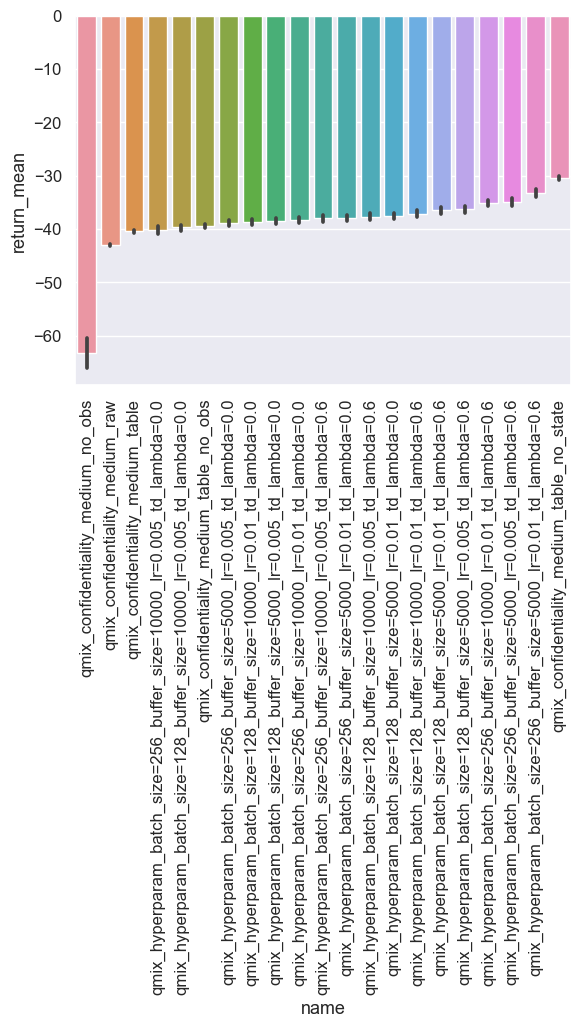

In [37]:

sort_order = df_cv.sort_values('return_mean')['name']
g = sns.barplot(
    data=df, x='name', y='return_mean',
    order=sort_order
)

plt.xticks(rotation=90)

Get heuristic data

In [26]:
df_conv = df.loc[df['ts'] == 998160.0][['algorithm', 'map_name', 'return_stdev', 'return_mean']]

df_mean = df_conv.groupby(['algorithm', 'map_name'])['return_mean', 'return_stdev'].mean().reset_index()


print(df_mean)

df_mean.to_csv('./datasets/phase1_1M_stdev.csv')

#stdev = df_conv.loc[df_conv['ts'], 'return_stdev']
#print('Stdev:', stdev)

   algorithm                map_name  return_mean  return_stdev
0        iql       availability_easy    -2.889048      3.314428
1        iql       availability_hard    -3.291369      2.315677
2        iql     availability_medium   -38.586429     27.842428
3        iql    confidentiality_easy  -165.193810     47.215810
4        iql    confidentiality_hard   -44.384464     24.408895
5        iql  confidentiality_medium   -74.123631     38.347645
6        iql          integrity_easy  -135.509643     63.331039
7        iql          integrity_hard   -12.645714      6.359111
8        iql        integrity_medium   -14.195774     12.191437
9       qmix       availability_easy    -3.524872      3.244128
10      qmix       availability_hard    -2.936012      2.339580
11      qmix     availability_medium   -33.219990     25.723379
12      qmix    confidentiality_easy  -219.797560     18.677123
13      qmix    confidentiality_hard   -43.661845     22.723484
14      qmix  confidentiality_medium   -

C:\Users\wiebe\AppData\Local\Temp\ipykernel_30940\3330087694.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_mean = df_conv.groupby(['algorithm', 'map_name'])['return_mean', 'return_stdev'].mean().reset_index()


In [23]:
def within_one_stdev(row):
    iql_mean = row['return_mean']
    qmix_mean = row['return_mean']
    stdev = row['return_stdev']
    if abs(iql_mean - qmix_mean) <= stdev:
        return True
    else:
        return False

df_mean['within_one_stdev'] = df.apply(within_one_stdev, axis=1)
print(df_mean)

   algorithm                map_name  return_mean  return_stdev  \
0        iql       availability_easy    -3.389821      3.278751   
1        iql       availability_hard    -3.850000      2.437045   
2        iql     availability_medium   -36.569702     26.261451   
3        iql    confidentiality_easy  -166.328988     55.769792   
4        iql    confidentiality_hard   -44.847857     24.223731   
5        iql  confidentiality_medium   -80.001190     38.443653   
6        iql          integrity_easy   -99.340417     51.958131   
7        iql          integrity_hard   -12.679702      6.364152   
8        iql        integrity_medium   -14.955893     13.914883   
9       qmix       availability_easy    -4.080060      3.362486   
10      qmix       availability_hard    -3.493899      2.215589   
11      qmix     availability_medium   -37.124603     26.517726   
12      qmix    confidentiality_easy  -225.301012     13.406933   
13      qmix    confidentiality_hard   -44.222857     23.16844